# Integrated System Simulation

In [39]:
from platform_optimization import create_platform_MPC
from platform_dynamics import pump_Q, gtg_P, Nx_p, Nu_p
from wf_optimization import create_wf_MPC
from wf_parameters import Nx_w, Nu_w, P_MAX
from wf_dynamics import wtg_power
from platform_parameters import *
from scheduler_optimizer import create_scheduler_MPC
from scheduler_parameters import *
from weather.get_weather_data import get_weather_data

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from casadi import vertcat


## Time Parameters

In [40]:
hours = 24*7
seconds = hours*3600

test_seconds = 60*60*24*7 

## Wind Conditions

Text(0, 0.5, '$v$ [m/s]')

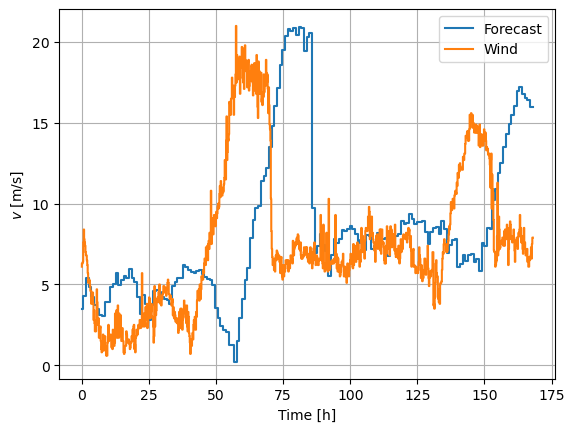

In [46]:
forecast, wind = get_weather_data(start=1000, duration=hours)

# 70 uke kan vaere en god test for veldig variert mengde vind på ulike dager, men god værmelding 170 enda bedre for dette kanskje??
# 620 uke er ekstremt god vaermelding også 640, den er også variert

# prøver 1002 uke fordi det bommer ganske kraftig der ved 2 anledninger

tf = np.linspace(0,hours, len(forecast))
tw = np.linspace(0,hours, len(wind))

sns.lineplot(x=tf, y=forecast, label='Forecast', drawstyle='steps')
sns.lineplot(x=tw, y=wind, label='Wind', drawstyle='steps')
plt.grid()
plt.xlabel('Time [h]')
plt.ylabel('$v$ [m/s]')

## Platform MPC

In [42]:
T_p = 10
N_p = 10
dt_p = T_p / N_p
#datapoints_p = int(seconds / dt_p)
datapoints_p = int(test_seconds / dt_p)
MPC_p1 = create_platform_MPC(T_p, N_p)
MPC_p2 = create_platform_MPC(T_p, N_p)

opti_p1 = MPC_p1['opti']
F_p1 = MPC_p1['intg']
x_p1 = MPC_p1['x']
u_p1 = MPC_p1['u']
x0_p1 = MPC_p1['x0']
Qd_p1 = MPC_p1['Qd']
Pdel_p1 = MPC_p1['Pdel']
s_p1 = MPC_p1['s']

opti_p2 = MPC_p2['opti']
F_p2 = MPC_p2['intg']
x_p2 = MPC_p2['x']
u_p2 = MPC_p2['u']
x0_p2 = MPC_p2['x0']
Qd_p2 = MPC_p2['Qd']
Pdel_p2 = MPC_p2['Pdel']
s_p2 = MPC_p2['s']

states_p1 = np.zeros( (Nx_p, datapoints_p) )
inputs_p1 = np.zeros( (Nu_p, datapoints_p-1) )
Qd_values_p1 = np.zeros(datapoints_p)
slacks_p1 = np.zeros(datapoints_p)
Pdel_values_p1 = np.zeros(datapoints_p)

states_p2 = np.zeros( (Nx_p, datapoints_p) )
inputs_p2 = np.zeros( (Nu_p, datapoints_p-1) )
Qd_values_p2 = np.zeros(datapoints_p)
slacks_p2 = np.zeros(datapoints_p)
Pdel_values_p2 = np.zeros(datapoints_p)

Q_max = pump_Q(Pp_max)        # Max pumping pr second [m3/s]
Q_max

764.525993883792

In [9]:
x0_p1_val = [Pp0, Q0, V0, Pl0, gamma0, V0, Pl0, gamma0]
x0_p2_val = [Pp0, Q0, V0, Pl0, gamma0, V0, Pl0, gamma0]

opti_p1.set_value(x0_p1, x0_p1_val)
#opti_p1.set_value(Qd_p1, 1)

#opti_p1.set_value(Pdel_p1, 0.5)
#opti_p2.set_value(Pdel_p2, 0.3)

opti_p2.set_value(x0_p2, x0_p2_val)
#opti_p2.set_value(Qd_p2, 1)

states_p1[:,0] = x0_p1_val
states_p2[:,0] = x0_p2_val

## Wind Farm MPC

In [10]:
# Time and simulation parameters
T_w = 60
N_w = 10
dt_w = T_w / N_w
#datapoints_w = int(seconds / dt_w)
datapoints_w = int(test_seconds / dt_w)

In [11]:
MPC_w = create_wf_MPC(T_w, N_w)

opti_w = MPC_w['opti']
F_w = MPC_w['intg']
x_w = MPC_w['x']
u_w = MPC_w['u']
x0_w = MPC_w['x0']
setpoints_w = MPC_w['setpoints']
v_w = MPC_w['v']

states_w = np.zeros( (Nx_w, datapoints_w+1) )
inputs_w = np.zeros( (Nu_w, datapoints_w) )
setpoint_values = np.zeros( (5, datapoints_w+1) )

x0_values_w = [0, 0, 0, 0.4, 0, 0, 0]
#opti_w.set_value(v_w, np.ones(N_w)*10)                             # Wind constantly 5, need to change
opti_w.set_value(x0_w, x0_values_w)
#opti_w.set_value(setpoints_w, [8000/P_MAX, 2000/P_MAX, 0/P_MAX, 0/P_MAX, 1000/P_MAX])        # [Pdist1d, Pdist2d, Pb1d, Pb2d, Pcharge_d] coming from scheduler
#opti_w.set_value(setpoints_w, [0.6487625568538287, 0.34875864771679504, 1.4140632131520267e-08, 1.4051142768975819e-08, 4.325271003338693e-08])        # [Pdist1d, Pdist2d, Pb1d, Pb2d, Pcharge_d] coming from scheduler


states_w[:,0] = x0_values_w

## Scheduler MPC

In [12]:
hours = int(test_seconds / 3600)
T_s = hours
N_s = 2*T_s + 1
dt_s = 0.5

In [13]:
V_max = hours*Q_max*3600
V_target_1_init = 0.6
V_target_2_init = 0.2
V_target_1_unscaled = V_max*V_target_1_init
V_target_2_unscaled = V_max*V_target_2_init
V_target_1 = V_target_1_init
V_target_2 = V_target_2_init

SOC_ref = 0.7
#wind = np.zeros(N_s-1)
#wind[int(N_s/2):] = 10
#wind[int(N_s/4):] = 15
#wind[int(N_s/6):int(N_s/5)] = 6

SOC = np.zeros(N_s)
WTG = np.zeros( (2,N_s-1) )
b = np.zeros( (2,N_s-1) )
charge = np.zeros(N_s-1)
pump_rate = np.zeros( (2,N_s-1) )
slacks = np.zeros( (2,N_s-1) )
volume = np.zeros((2,N_s))
gtg_prod = np.zeros( (4,N_s-1) )

SOC_0 = 0.4
SOC[0] = SOC_0
iterations = N_s

## Simulation Loop

In [14]:
for i in range(datapoints_p - 1):

    #! Solution for scheduler
    if i % int(dt_s*3600) == 0:
        idx = int(i/(dt_s*3600))
        print("idx = ", idx, "Time simulated = ", idx*0.5, " Hours")

        MPC_s = create_scheduler_MPC(T_s, N_s)

        opti_s = MPC_s['opti']
        F_s = MPC_s['intg']
        x_s = MPC_s['x']
        s_s = MPC_s['s']
        x0_s = MPC_s['x0']
        P_WTG_s = MPC_s['P_WTG']
        P_charge_s = MPC_s['P_charge']
        P_b_s = MPC_s['P_b']
        P_expected_s = MPC_s['P_expected']
        V_target_s = MPC_s['V_target']
        SOC_d_s = MPC_s['SOC_d']
        Q_s = MPC_s['Q']
        P_l_s = MPC_s['P_l']

        # Setting param values
        if idx == 0:
            opti_s.set_value(x0_s, SOC[idx])
        else:
            opti_s.set_value(x0_s, actual_SOC)
        #opti_s.set_value(P_expected_s, wind_power_fancy(wind[idx:])/P_MAX)
        #opti_s.set_value(P_expected_s, wind_power_fit(forecast[idx:])/P_MAX)
        opti_s.set_value(P_expected_s, wtg_power(forecast[idx:]))
        opti_s.set_value(SOC_d_s, SOC_ref)

        #! Setting volume target
        V_max_updated = T_s*Q_max*3600
        V_target_1 = (V_target_1_unscaled - sum(states_p1[1,:i+1])*Q_max) / V_max_updated
        V_target_2 = (V_target_2_unscaled - sum(states_p2[1,:i+1])*Q_max) / V_max_updated
        #print("Targets: ", V_target_1, V_target_2)
        opti_s.set_value(V_target_s, [V_target_1, V_target_2])

        sol_s = opti_s.solve()

        if idx == iterations - 2:
            WTG[:,idx] = sol_s.value(P_WTG_s)[:]
            b[:,idx] = sol_s.value(P_b_s)[:]
            charge[idx] = sol_s.value(P_charge_s)
            pump_rate[:,idx] = sol_s.value(Q_s)[:]
            gtg_prod[:,idx] = sol_s.value(P_l_s)[:]
            slacks[:,idx] = sol_s.value(s_s)
        else:
            WTG[:,idx] = sol_s.value(P_WTG_s)[:,0]
            b[:,idx] = sol_s.value(P_b_s)[:,0]
            charge[idx] = sol_s.value(P_charge_s)[0]
            pump_rate[:,idx] = sol_s.value(Q_s)[:,0]
            gtg_prod[:,idx] = sol_s.value(P_l_s)[:,0]
            slacks[:,idx] = sol_s.value(s_s)

        SOC[idx+1] = F_s( SOC[idx], vertcat(charge[idx], b[:,idx]) )

        #volume[0,idx+1] = pump_rate[0,idx]*1800*Q_max
        #volume[1,idx+1] = pump_rate[1,idx]*1800*Q_max

        N_s -= 1
        T_s = dt_s*(N_s-1)

        # Calculating new V_targets
        #V_max_updated = T_s*Q_max*3600
        #V_target_1 = (V_target_1_unscaled - np.sum(volume[0,:idx+2])) / V_max_updated
        #V_target_2 = (V_target_2_unscaled - np.sum(volume[1,:idx+2])) / V_max_updated

        #! Setting pumping-rate references for platform controllers
        opti_p1.set_value(Qd_p1, pump_rate[0,idx])
        opti_p2.set_value(Qd_p2, pump_rate[1,idx])

        #! Setting target references for wind farm controller   # [Pdist1d, Pdist2d, Pb1d, Pb2d, Pcharge_d]
        opti_w.set_value(setpoints_w, [WTG[0,idx], WTG[1,idx], b[0,idx], b[1,idx], charge[idx]])

        #! Setting wind conditions for windfarm controller
        #opti_w.set_value(v_w, [wind[idx]]*N_w)

    

    #! solution for windfarm
    if i % dt_w == 0:

        #! Setting wind conditions
        if i % 60*10 == 0:      # Every 10th minute
            wind_idx = int(i / (60*10))
            opti_w.set_value(v_w, wind[wind_idx])

        idx = int(i/dt_w)

        sol_w = opti_w.solve()
        inputs_w[:,idx] = sol_w.value(u_w)[:,0]

        # Incrementing state using optimal inputs
        states_w[:,idx+1] = np.reshape(F_w( states_w[:,idx], inputs_w[:,idx], sol_w.value(v_w) ), (Nx_w,))  

        # Storing desired setpoint data
        setpoint_values[:,idx] = sol_w.value(setpoints_w)[:]
        
        # Updating initial guess to previous solution (next solution assumed to be close to previous solution)
        #opti_w.set_initial(x_w, sol_w.value(x_w))
        #opti_w.set_initial(u_w, sol_w.value(u_w))

        opti_w.set_initial(x_w, np.full((Nx_w, N_w), 0.5))
        opti_w.set_initial(u_w, np.zeros((Nu_w, N_w-1)))

        # Updating starting point x0
        opti_w.set_value(x0_w, states_w[:,idx+1])

        #! Setting parameter to platforms
        opti_p1.set_value(Pdel_p1, (states_w[1,idx+1]*P_MAX + states_w[4,idx+1]*P_MAX) / Pdel_max)
        opti_p2.set_value(Pdel_p2, (states_w[2,idx+1]*P_MAX + states_w[5,idx+1]*P_MAX) / Pdel_max)

        actual_SOC = states_w[3,idx]


    #! Solution for platforms
    sol_p1 = opti_p1.solve()
    inputs_p1[:,i] = sol_p1.value(u_p1)[:,0]
    Qd_values_p1[i] = sol_p1.value(Qd_p1)*Q_max
    slacks_p1[i] = sol_p1.value(s_p1[0])
    Pdel_values_p1[i] = sol_p1.value(Pdel_p1)

    states_p1[:,i+1] = np.reshape(F_p1( states_p1[:,i], inputs_p1[:,i] ), (Nx_p,))
    
    # Updating initial guess to previous solution (next solution should be close to previous)
    opti_p1.set_initial(x_p1, sol_p1.value(x_p1))
    opti_p1.set_initial(u_p1, sol_p1.value(u_p1))

    # Updating starting point x0
    opti_p1.set_value(x0_p1, states_p1[:,i+1])

    sol_p2 = opti_p2.solve()
    inputs_p2[:,i] = sol_p2.value(u_p2)[:,0]
    Qd_values_p2[i] = sol_p2.value(Qd_p2)*Q_max
    slacks_p2[i] = sol_p2.value(s_p2[0])
    Pdel_values_p2[i] = sol_p2.value(Pdel_p2)

    states_p2[:,i+1] = np.reshape(F_p2( states_p2[:,i], inputs_p2[:,i] ), (Nx_p,))
    
    # Updating initial guess to previous solution (next solution should be close to previous)
    opti_p2.set_initial(x_p2, sol_p2.value(x_p2))
    opti_p2.set_initial(u_p2, sol_p2.value(u_p2))

    # Updating starting point x0
    opti_p2.set_value(x0_p2, states_p2[:,i+1])

idx =  0 Time simulated =  0.0  Hours

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

idx =  1 Time simulated =  0.5  Hours
idx =  2 Time simulated =  1.0  Hours
idx =  3 Time simulated =  1.5  Hours
idx =  4 Time simulated =  2.0  Hours
idx =  5 Time simulated =  2.5  Hours
idx =  6 Time simulated =  3.0  Hours
idx =  7 Time simulated =  3.5  Hours
idx =  8 Time simulated =  4.0  Hours
idx =  9 Time simulated =  4.5  Hours
idx =  10 Time simulated =  5.0  Hours
idx =  11 Time simulated =  5.5  Hours
idx =  12 Time simulated =  6.0  Hours
idx =  13 Time simulated =  6.5  Hours
idx =  14 Time simulated =  7.0  Hours
idx =  15 Time simulated =  7.5  Hours

In [15]:
t_p = np.linspace(0, seconds, int(seconds/dt_p))
t_w = np.linspace(0, seconds, int(seconds/dt_w)+1)
t_s = np.linspace(0, hours, int(2*hours+1))

t_p = np.linspace(0, hours, int(test_seconds/dt_p))
t_w = np.linspace(0, hours, int(test_seconds/dt_w)+1)

## Platform Analysis

<AxesSubplot:title={'center':'GTG Throttle'}>

c:\Users\HSH\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


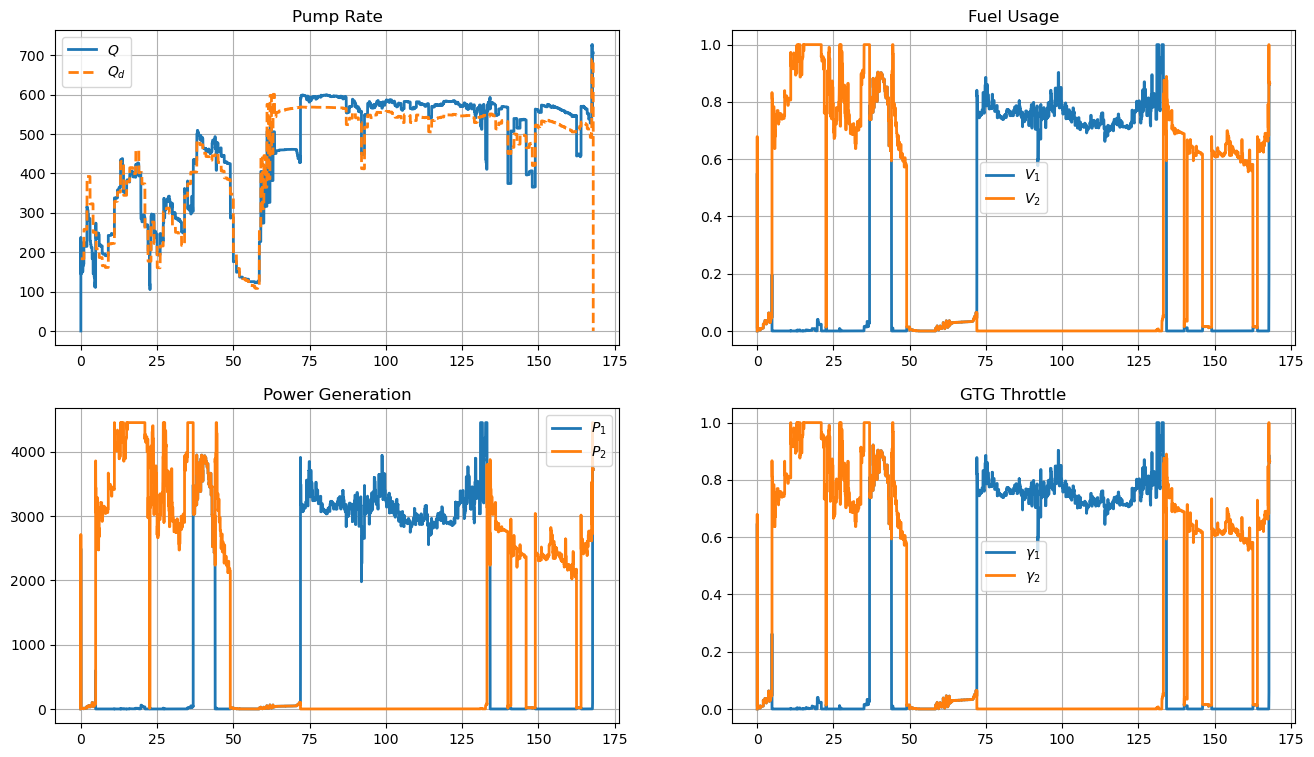

In [16]:
fig, axes = plt.subplots(2,2, figsize=(16,9))

axes[0][0].set_title("Pump Rate")
axes[0][0].grid()
sns.lineplot(ax=axes[0][0], x=t_p, y=states_p1[1,:]*Q_max, lw=2, label='$Q$')
sns.lineplot(ax=axes[0][0], x=t_p, y=Qd_values_p1, lw=2, label='$Q_d$', linestyle='dashed')

axes[0][1].set_title("Fuel Usage")
axes[0][1].grid()
sns.lineplot(ax=axes[0][1], x=t_p, y=states_p1[2,:], lw=2, label='$V_1$')
sns.lineplot(ax=axes[0][1], x=t_p, y=states_p1[5,:], lw=2, label='$V_2$')

axes[1][0].set_title("Power Generation")
axes[1][0].grid()
sns.lineplot(ax=axes[1][0], x=t_p, y=gtg_P(states_p1[3,:]), lw=2, label='$P_1$')
sns.lineplot(ax=axes[1][0], x=t_p, y=gtg_P(states_p1[6,:]), lw=2, label='$P_2$')

axes[1][1].set_title("GTG Throttle")
axes[1][1].grid()
sns.lineplot(ax=axes[1][1], x=t_p, y=states_p1[4,:], lw=2, label='$\gamma_1$')
sns.lineplot(ax=axes[1][1], x=t_p, y=states_p1[7,:], lw=2, label='$\gamma_2$')

<AxesSubplot:title={'center':'GTG Throttle'}>

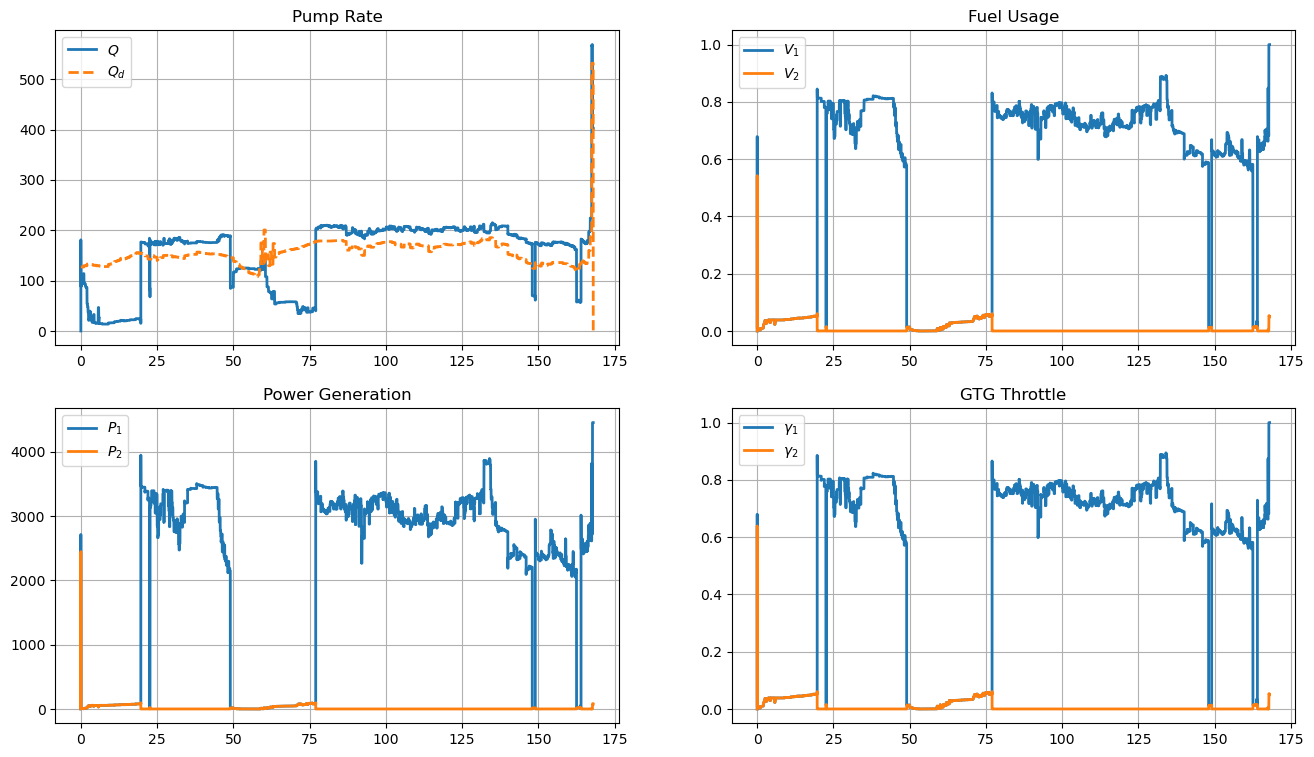

In [17]:
fig, axes = plt.subplots(2,2, figsize=(16,9))

axes[0][0].set_title("Pump Rate")
axes[0][0].grid()
sns.lineplot(ax=axes[0][0], x=t_p, y=states_p2[1,:]*Q_max, lw=2, label='$Q$')
sns.lineplot(ax=axes[0][0], x=t_p, y=Qd_values_p2, lw=2, label='$Q_d$', linestyle='dashed')

axes[0][1].set_title("Fuel Usage")
axes[0][1].grid()
sns.lineplot(ax=axes[0][1], x=t_p, y=states_p2[2,:], lw=2, label='$V_1$')
sns.lineplot(ax=axes[0][1], x=t_p, y=states_p2[5,:], lw=2, label='$V_2$')

axes[1][0].set_title("Power Generation")
axes[1][0].grid()
sns.lineplot(ax=axes[1][0], x=t_p, y=gtg_P(states_p2[3,:]), lw=2, label='$P_1$')
sns.lineplot(ax=axes[1][0], x=t_p, y=gtg_P(states_p2[6,:]), lw=2, label='$P_2$')

axes[1][1].set_title("GTG Throttle")
axes[1][1].grid()
sns.lineplot(ax=axes[1][1], x=t_p, y=states_p2[4,:], lw=2, label='$\gamma_1$')
sns.lineplot(ax=axes[1][1], x=t_p, y=states_p2[7,:], lw=2, label='$\gamma_2$')

## Wind Farm Analysis

<AxesSubplot:title={'center':'Battery Power Distributions'}, xlabel='$t$ [h]', ylabel='$P$ [kW]'>

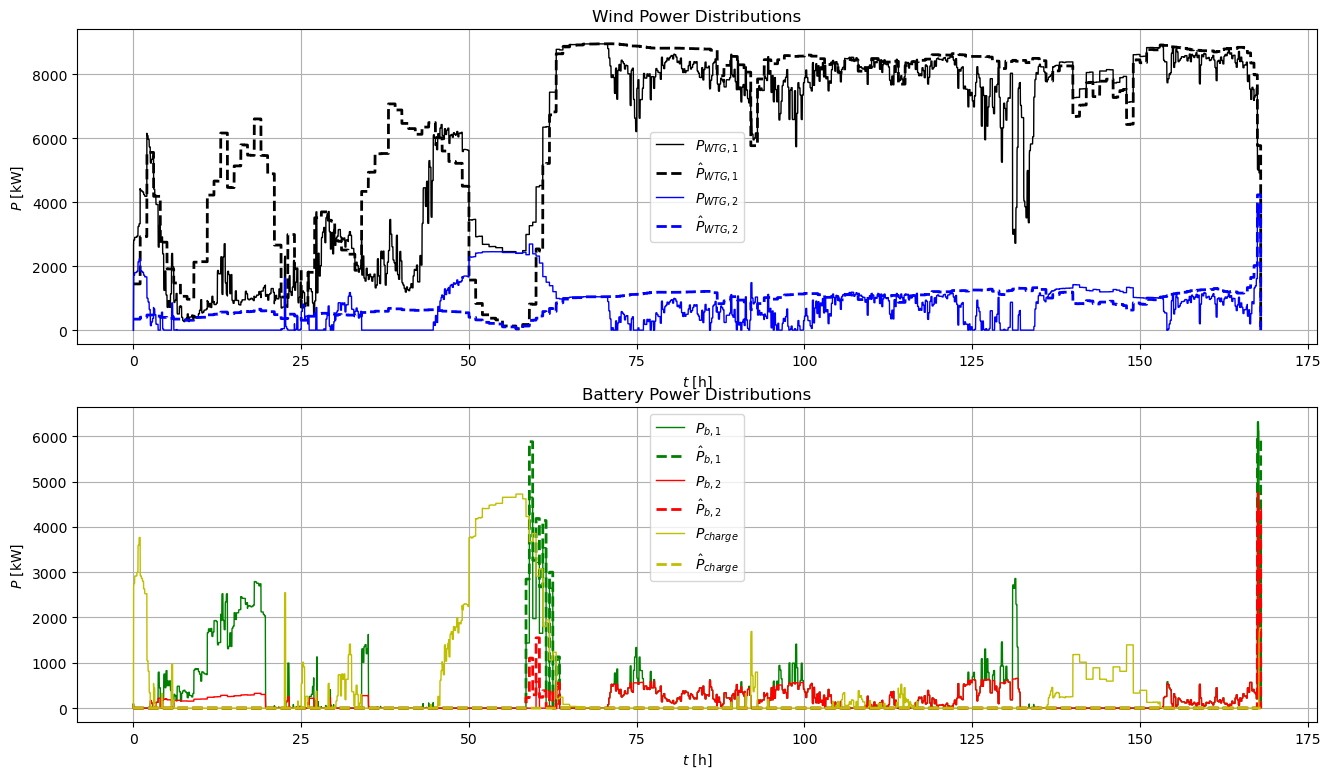

In [18]:
# x =                               [P, Pdist1, Pdist2, SOC, Pb1, Pb2, Pcharge]
# u =                               [dPdist1, dPdist2, dPb1, dPb2, dPcharge]
# setpoints =                       [Pdist1d, Pdist2d, Pb1d, Pb2d, Pcharge_d] coming from scheduler

fig, axes = plt.subplots(2,1, figsize=(16,9))
axes[0].grid()
axes[0].set_title('Wind Power Distributions')
axes[0].set_xlabel('$t$ [h]')
axes[0].set_ylabel('$P$ [kW]')

axes[1].grid()
axes[1].set_title('Battery Power Distributions')
axes[1].set_xlabel('$t$ [h]')
axes[1].set_ylabel('$P$ [kW]')

sns.lineplot(ax=axes[0], x=t_w, y=states_w[1,:]*P_MAX, label='$P_{WTG,1}$', lw=1, color='k')
sns.lineplot(ax=axes[0], x=t_w, y=setpoint_values[0,:]*P_MAX, label='$\hat{P}_{WTG,1}$', linestyle='dashed', color='k', lw=2)
sns.lineplot(ax=axes[0], x=t_w, y=states_w[2,:]*P_MAX, label='$P_{WTG,2}$', lw=1, color='b')
sns.lineplot(ax=axes[0], x=t_w, y=setpoint_values[1,:]*P_MAX, label='$\hat{P}_{WTG,2}$', linestyle='dashed', color='b', lw=2)
sns.lineplot(ax=axes[1], x=t_w, y=states_w[4,:]*P_MAX, label='$P_{b,1}$', lw=1, color='g')
sns.lineplot(ax=axes[1], x=t_w, y=setpoint_values[2,:]*P_MAX, label='$\hat{P}_{b,1}$', linestyle='dashed', color='g', lw=2)
sns.lineplot(ax=axes[1], x=t_w, y=states_w[5,:]*P_MAX, label='$P_{b,2}$', lw=1, color='r')
sns.lineplot(ax=axes[1], x=t_w, y=setpoint_values[3,:]*P_MAX, label='$\hat{P}_{b,2}$', linestyle='dashed', color='r', lw=2)
sns.lineplot(ax=axes[1], x=t_w, y=states_w[6,:]*P_MAX, label='$P_{charge}$', lw=1, color='y')
sns.lineplot(ax=axes[1], x=t_w, y=setpoint_values[4,:]*P_MAX, label='$\hat{P}_{charge}$', linestyle='dashed', color='y', lw=2)

<AxesSubplot:title={'center':'State of Charge'}, xlabel='$t$ [h]', ylabel='$SOC$'>

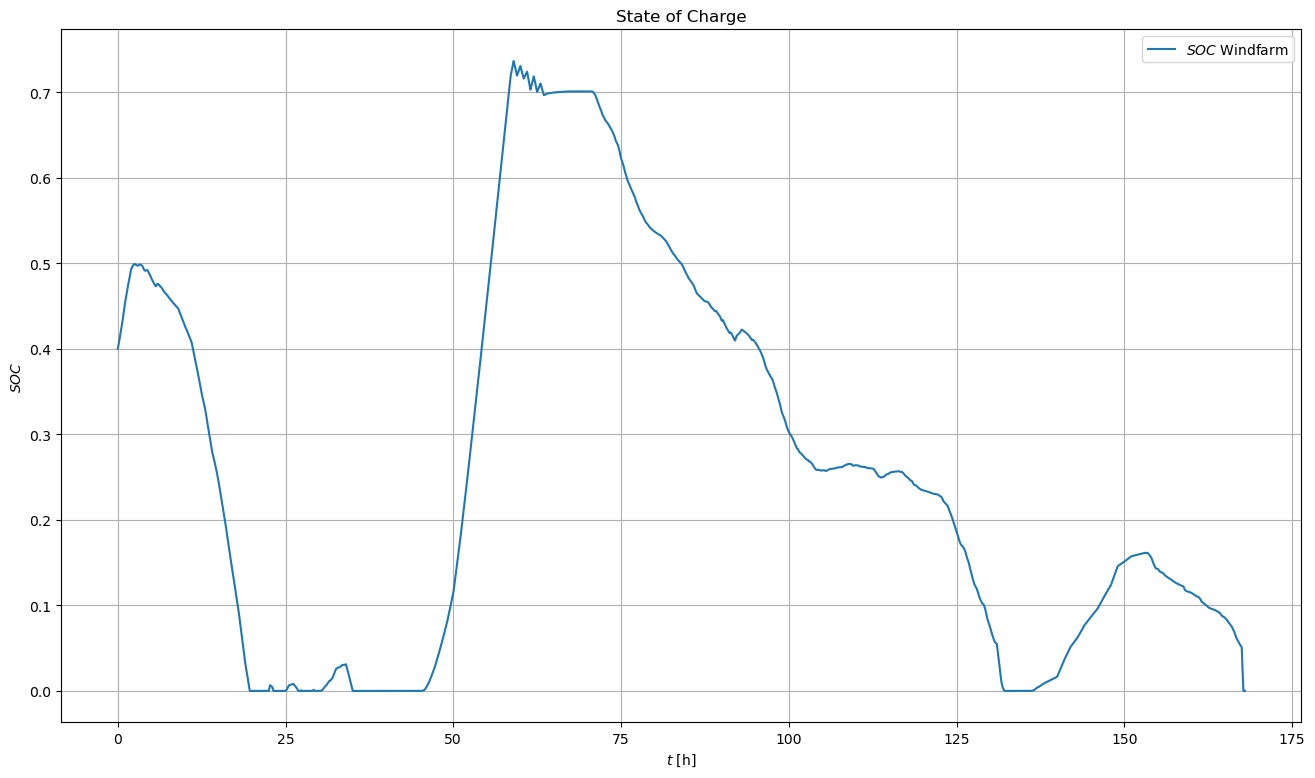

In [19]:
fig = plt.figure(figsize=(16,9))
plt.grid()
plt.title('State of Charge')
plt.xlabel('$t$ [h]')
plt.ylabel("$SOC$")

sns.lineplot(x=t_w, y=states_w[3,:], label='$SOC$ Windfarm')

<AxesSubplot:title={'center':'WTG Energy Balance'}, xlabel='$t$ [s]', ylabel='$P$ [kW]'>

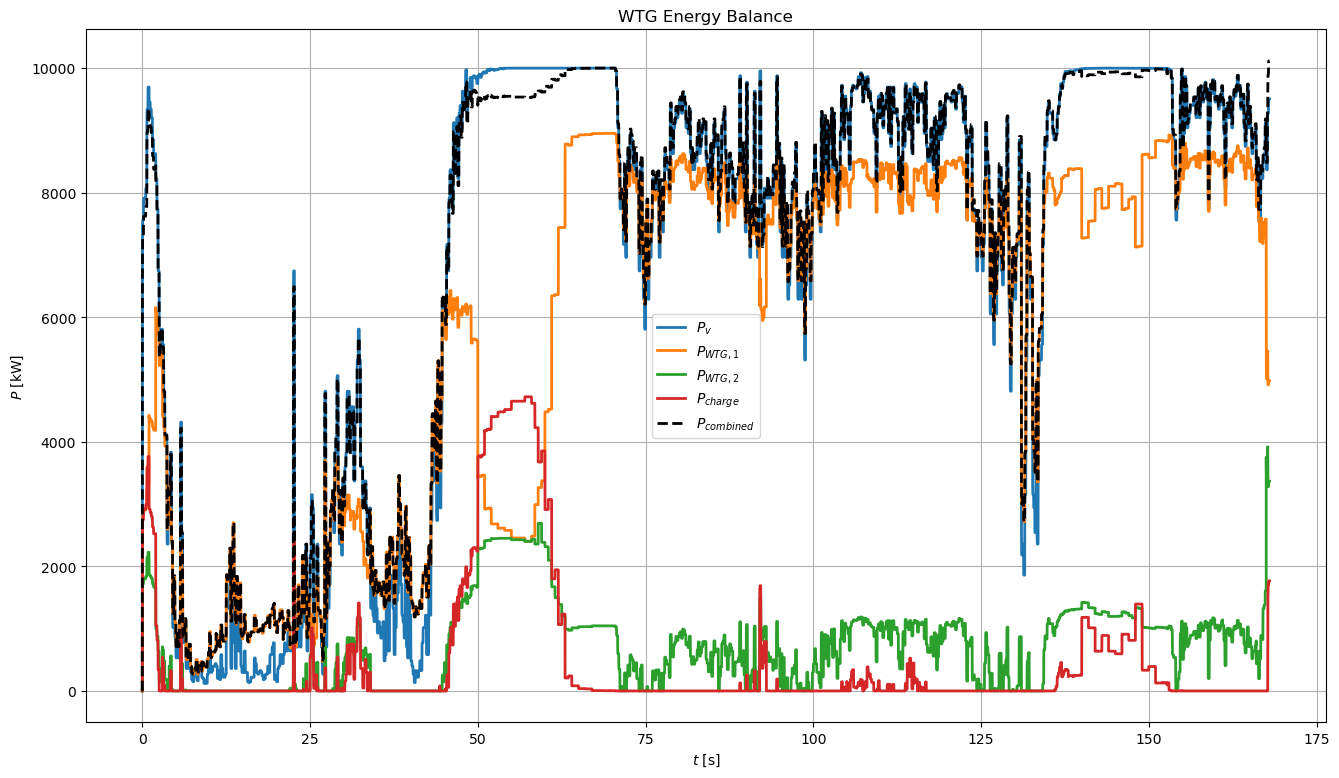

In [20]:
fig = plt.figure(figsize=(16,9))
plt.grid()
plt.xlabel('$t$ [s]')
plt.ylabel('$P$ [kW]')
plt.title('WTG Energy Balance')

sns.lineplot(x=t_w, y=states_w[0,:]*P_MAX, label='$P_{v}$', lw=2)
sns.lineplot(x=t_w, y=states_w[1,:]*P_MAX, label='$P_{WTG,1}$', lw=2)
sns.lineplot(x=t_w, y=states_w[2,:]*P_MAX, label='$P_{WTG,2}$', lw=2)
sns.lineplot(x=t_w, y=states_w[-1,:]*P_MAX, label='$P_{charge}$', lw=2)
sns.lineplot(x=t_w, y=states_w[-1,:]*P_MAX + states_w[1,:]*P_MAX + states_w[2,:]*P_MAX, label='$P_{combined}$', lw=2, linestyle='dashed', color='k')

<AxesSubplot:title={'center':'Power Generated vs. Expected'}, xlabel='$t$ [h]', ylabel='$P$ [kW]'>

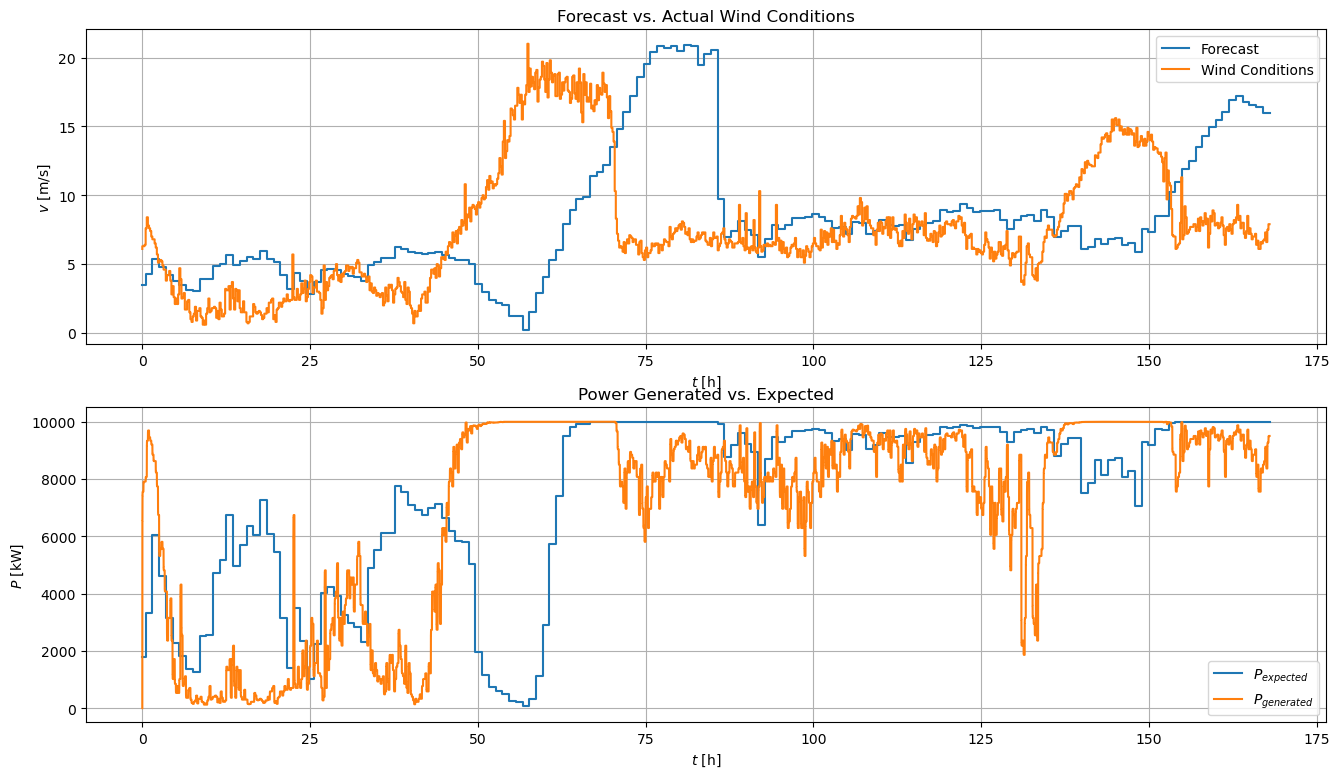

In [21]:
#! Generated power from WTG vs. expected, with second graph on wind conditions vs forecast
fig, axes = plt.subplots(2,1, figsize=(16,9))
axes[0].grid()
axes[0].set_title('Forecast vs. Actual Wind Conditions')
axes[0].set_xlabel('$t$ [h]')
axes[0].set_ylabel('$v$ [m/s]')

axes[1].grid()
axes[1].set_title('Power Generated vs. Expected')
axes[1].set_xlabel('$t$ [h]')
axes[1].set_ylabel('$P$ [kW]')

sns.lineplot(ax=axes[0], x=tf, y=forecast, label='Forecast', drawstyle='steps')
sns.lineplot(ax=axes[0], x=tw, y=wind, label='Wind Conditions', drawstyle='steps')

sns.lineplot(ax=axes[1], x=tf, y=wtg_power(forecast)*P_MAX, label='$P_{expected}$', drawstyle='steps')
sns.lineplot(ax=axes[1], x=t_w, y=states_w[0,:]*P_MAX, label='$P_{generated}$', drawstyle='steps')

## Scheduler Analysis

<AxesSubplot:title={'center':'Pumping Rates'}, xlabel='$t$ [h]', ylabel='$Q$ [$m^3/s$]'>

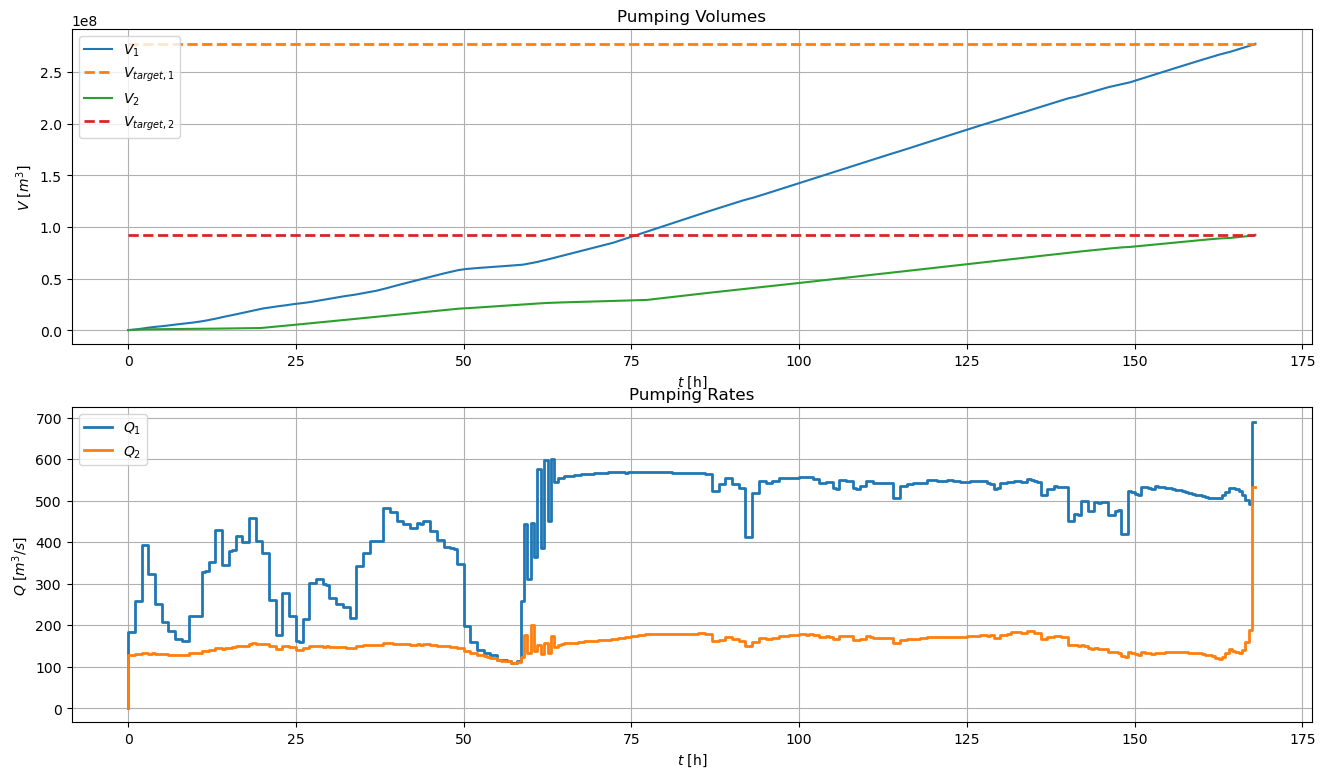

In [22]:
fig, axes = plt.subplots(2,1, figsize=(16,9))

axes[0].grid()
axes[0].set_title('Pumping Volumes')
axes[0].set_xlabel('$t$ [h]')
axes[0].set_ylabel('$V$ [$m^3$]')
sns.lineplot(ax=axes[0], x=t_p, y=np.cumsum(states_p1[1,:])*Q_max, label='$V_1$')
#sns.lineplot(ax=axes[0], x=t_s, y=np.cumsum(volume[0,:]), label='$V_1$')
sns.lineplot(ax=axes[0], x=t_s, y=V_target_1_unscaled*np.ones(len(t_s)), lw=2, label='$V_{target,1}$', linestyle='dashed')
sns.lineplot(ax=axes[0], x=t_p, y=np.cumsum(states_p2[1,:])*Q_max, label='$V_2$')
#sns.lineplot(ax=axes[0], x=t_s, y=np.cumsum(volume[1,:]), label='$V_2$')
sns.lineplot(ax=axes[0], x=t_s, y=V_target_2_unscaled*np.ones(len(t_s)), lw=2, label='$V_{target,2}$', linestyle='dashed')


axes[1].grid()
axes[1].set_title('Pumping Rates')
axes[1].set_xlabel('$t$ [h]')
axes[1].set_ylabel('$Q$ [$m^3/s$]')

new_pump_rate = np.zeros((2,int(2*hours+1)))
new_pump_rate[0,1:] = pump_rate[0,:]
new_pump_rate[1,1:] = pump_rate[1,:]

sns.lineplot(ax=axes[1], x=t_s, y=new_pump_rate[0,:]*Q_max,  lw=2, label='$Q_1$', drawstyle='steps-pre')
sns.lineplot(ax=axes[1], x=t_s, y=new_pump_rate[1,:]*Q_max,  lw=2, label='$Q_2$', drawstyle='steps-pre')

### Storing Data

In [23]:
import pandas as pd

### Platforms

In [24]:
platform1_p = np.zeros((3,datapoints_p))
platform1_p[0,:] = Pdel_values_p1
platform1_p[1,:] = Qd_values_p1
platform1_p[2,:] = slacks_p1

platform2_p = np.zeros((3,datapoints_p))
platform2_p[0,:] = Pdel_values_p2
platform2_p[1,:] = Qd_values_p2
platform2_p[2,:] = slacks_p2

In [25]:
platform_x_cols = ['P', 'Q', 'V1', 'Pl1', 'gamma1', 'V2', 'Pl2', 'gamma2']
platform_u_cols = ['dP', 'dgamma1', 'dgamma2']
platform_p_cols = ['Pdel', 'Qd', 's']

platform1_x_df = pd.DataFrame(states_p1.T, columns=platform_x_cols)
platform1_u_df = pd.DataFrame(inputs_p1.T, columns=platform_u_cols)
platform1_p_df = pd.DataFrame(platform1_p.T, columns=platform_p_cols)

platform2_x_df = pd.DataFrame(states_p2.T, columns=platform_x_cols)
platform2_u_df = pd.DataFrame(inputs_p2.T, columns=platform_u_cols)
platform2_p_df = pd.DataFrame(platform2_p.T, columns=platform_p_cols)

In [26]:
platform1_x_df.head()

,P,Q,V1,Pl1,gamma1,V2,Pl2,gamma2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.089763,0.019168,0.031568,0.000000,0.047352,0.031568,0.000000,0.047352
2,0.098067,0.048701,0.175424,0.042091,0.247352,0.175424,0.042091,0.247352
3,0.163009,0.081981,0.356709,0.226883,0.447352,0.356709,0.226883,0.447352
4,0.279051,0.138623,0.550471,0.434291,0.647352,0.550471,0.434291,0.647352


In [27]:
platform1_u_df.head()

,dP,dgamma1,dgamma2
0,0.089763,0.047352,0.047352
1,0.008304,0.200000,0.200000
2,0.064942,0.200000,0.200000
3,0.116042,0.200000,0.200000
4,0.143427,-0.200000,-0.033085


In [28]:
platform1_p_df.head()

,Pdel,Qd,s
0,0.089763,183.35413,1.346440e+03
1,0.089763,183.35413,-6.698230e-07
2,0.089763,183.35413,-4.051889e-07
3,0.089763,183.35413,-2.484652e-07
4,0.089763,183.35413,-9.674462e-08


### Wind Farm

In [29]:
windfarm_x_df = pd.DataFrame(states_w.T, columns=['P', 'P_WTG1', 'P_WTG2', 'SOC', 'Pb1', 'Pb2', 'Pcharge'])
windfarm_u_df = pd.DataFrame(inputs_w.T, columns=['dPWTG1', 'dPWTG2', 'dPb1', 'dPb2', 'dPcharge'])
windfarm_p_df = pd.DataFrame(setpoint_values.T, columns=['P_WTG1', 'P_WTG2', 'Pb1', 'Pb2', 'Pcharge'])

In [30]:
windfarm_x_df.head()

,P,P_WTG1,P_WTG2,SOC,Pb1,Pb2,Pcharge
0,0.000000,0.000000,0.000000,0.400000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.137025,0.124900,0.015034,0.399997,9.743608e-03,9.642418e-03,3.320588e-08
2,0.249211,0.161186,0.051116,0.399998,1.098823e-07,1.139371e-07,3.355658e-02
3,0.341062,0.183075,0.073005,0.400013,6.519073e-08,7.093901e-08,7.725524e-02
4,0.416264,0.200979,0.090910,0.400038,2.446570e-08,2.571908e-08,1.130665e-01


In [31]:
windfarm_p_df.head()

,P_WTG1,P_WTG2,Pb1,Pb2,Pcharge
0,0.144442,0.034372,1.531209e-08,1.531208e-08,1.251443e-10
1,0.144442,0.034372,1.531209e-08,1.531208e-08,1.251443e-10
2,0.144442,0.034372,1.531209e-08,1.531208e-08,1.251443e-10
3,0.144442,0.034372,1.531209e-08,1.531208e-08,1.251443e-10
4,0.144442,0.034372,1.531209e-08,1.531208e-08,1.251443e-10


In [32]:
windfarm_u_df.head()

,dPWTG1,dPWTG2,dPb1,dPb2,dPcharge
0,0.020817,0.002506,1.623935e-03,1.607070e-03,5.534313e-09
1,0.006048,0.006014,-1.623916e-03,-1.607051e-03,5.592759e-03
2,0.003648,0.003648,-7.448602e-09,-7.166344e-09,7.283109e-03
3,0.002984,0.002984,-6.787506e-09,-7.536656e-09,5.968541e-03
4,0.002443,0.002443,-2.059603e-09,-2.192101e-09,4.886657e-03


### Scheduler

In [33]:
scheduler_values = np.zeros((iterations-1, 9))
scheduler_values[:,0:2] = WTG.T
scheduler_values[:,2:4] = b.T
scheduler_values[:,4] = charge
scheduler_values[:,5:9] = gtg_prod.T

scheduler_x_df = pd.DataFrame(scheduler_values, columns=['WTG1', 'WTG2', 'b1', 'b2', 'charge', 'gtg_prod1', 'gtg_prod2', 'gtg_prod3', 'gtg_prod4'])

In [34]:
scheduler_x_df.head()

,WTG1,WTG2,b1,b2,charge,gtg_prod1,gtg_prod2,gtg_prod3,gtg_prod4
0,0.144442,0.034372,1.531209e-08,1.531208e-08,1.251443e-10,0.359962,0.359962,0.359962,0.359962
1,0.144454,0.034360,1.794795e-08,1.807170e-08,-1.555216e-10,0.359439,0.359439,0.359439,0.359439
2,0.292035,0.040526,2.129256e-08,2.146174e-08,-4.329277e-10,0.358647,0.358647,0.358647,0.358647
3,0.292319,0.040241,2.382985e-08,2.382984e-08,-5.996500e-10,0.358101,0.358101,0.358101,0.358101
4,0.555741,0.047252,2.729546e-08,2.729571e-08,-7.833481e-10,0.357682,0.357682,0.357682,0.357682


## Storing in CSV Files

In [35]:
import os

In [36]:
# Platforms
p1_x_file = os.path.join('data', 'day1000_forecast_week_p1_x.csv')
p2_x_file = os.path.join('data', 'day1000_forecast_week_p2_x.csv')
p1_u_file = os.path.join('data', 'day1000_forecast_week_p1_u.csv')
p2_u_file = os.path.join('data', 'day1000_forecast_week_p2_u.csv')
p1_p_file = os.path.join('data', 'day1000_forecast_week_p1_p.csv')
p2_p_file = os.path.join('data', 'day1000_forecast_week_p2_p.csv')

platform1_x_df.to_csv(p1_x_file, index=False)
platform2_x_df.to_csv(p2_x_file, index=False)
platform1_u_df.to_csv(p1_u_file, index=False)
platform2_u_df.to_csv(p2_u_file, index=False)
platform1_p_df.to_csv(p1_p_file, index=False)
platform2_p_df.to_csv(p2_p_file, index=False)


In [37]:
# Wind Farm
wf_x_file = os.path.join('data', 'day1000_forecast_week_wf_x.csv')
wf_u_file = os.path.join('data', 'day1000_forecast_week_wf_u.csv')
wf_p_file = os.path.join('data', 'day1000_forecast_week_wf_p.csv')

windfarm_x_df.to_csv(wf_x_file, index=False)
windfarm_u_df.to_csv(wf_u_file, index=False)
windfarm_p_df.to_csv(wf_p_file, index=False)

In [38]:
# Scheduler
scheduler_file = os.path.join('data', 'day1000_forecast_week_scheduler.csv')
scheduler_x_df.to_csv(scheduler_file, index=False)